# What does a Win look like?

Here I am going to see if we can determine how strongly certain factors influence the result of a football match and whether we can use them to predict the result.

## Dataset exploration

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0, r'..\src')
import utilities

# access the source dataset
df = utilities.get_master("fulldata")

# create a more descriptive index field
df["MatchIndex"] = df["Team"] + " vs " + df["TeamOpp"] + " (" + df["Date"] + ")"
df.set_index('MatchIndex', inplace=True) #, verify_integrity=True)

# longlist of relevant features
features_list = ['Win', 'Attendance', 'Goals', 'GoalsOpp', 'Shots', 'ShotsOpp', 'ShotsOnTarget', 'ShotsOnTargetOpp', 'ShotsHitWoodwork', 'ShotsHitWoodworkOpp', 'Corners', 'CornersOpp', 'Fouls', 'FoulsOpp', 'Offsides', 'OffsidesOpp', 'YellowCards', 'YellowCardsOpp', 'RedCards', 'RedCardsOpp', 'BookingPoints', 'BookingPointsOpp', 'Saves', 'SavesOpp', 'CleanSheet', 'CleanSheetOpp']
df = df[features_list]

# remove patchy data (and duff indexes)
df.dropna(inplace=True)
df = df[df.index.notnull()]

# create a random sample
df = df.sample(n=4000, random_state=1)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Win,4000.0,0.37775,0.484885,0.0,0.0,0.0,1.00,1.0
Attendance,4000.0,13932.19600,14905.810960,150.0,3536.0,7229.0,20232.25,68600.0
Goals,4000.0,1.36850,1.241408,0.0,0.0,1.0,2.00,7.0
GoalsOpp,4000.0,1.33450,1.222081,0.0,0.0,1.0,2.00,8.0
Shots,4000.0,10.76450,4.553814,0.0,8.0,10.0,13.00,30.0
ShotsOpp,4000.0,10.68925,4.510850,0.0,7.0,10.0,14.00,41.0
ShotsOnTarget,4000.0,5.10850,2.725910,0.0,3.0,5.0,7.00,19.0
ShotsOnTargetOpp,4000.0,5.03000,2.654216,0.0,3.0,5.0,7.00,20.0
ShotsHitWoodwork,4000.0,0.30550,0.579011,0.0,0.0,0.0,1.00,4.0
ShotsHitWoodworkOpp,4000.0,0.31650,0.576551,0.0,0.0,0.0,1.00,4.0


In [2]:
# look at matches with most outlier features
IQR = df.quantile(q=0.75) - df.quantile(q=0.25)
first_quartile = df.quantile(q=0.25)
third_quartile = df.quantile(q=0.75)
outliers = df[(df>(third_quartile + 1.5*IQR) ) | (df<(first_quartile - 1.5*IQR) )].count(axis=1)
outliers.sort_values(axis=0, ascending=False, inplace=True)
outliers.head(12)

MatchIndex
Bayern Munich vs Dortmund (2000-11-04)         7
Leeds vs Arsenal (2001-08-21)                  6
Hamburg vs Hansa Rostock (2001-04-29)          6
FC Koln vs Hamburg (2001-04-15)                6
Man United vs Tottenham (2002-03-06)           6
Hansa Rostock vs Schalke 04 (2001-08-21)       6
Munich 1860 vs Dortmund (2001-02-02)           5
Ein Frankfurt vs Hansa Rostock (2001-02-04)    5
Newcastle vs Aston Villa (2001-05-19)          5
Ipswich vs Derby (2001-08-21)                  5
Sunderland vs Man United (2001-01-31)          5
Stenhousemuir vs Partick (2000-08-19)          5
dtype: int64

In [3]:
df.loc["Bayern Munich vs Dortmund (2000-11-04)", :]

Win                        1.0
Attendance             62000.0
Goals                      6.0
GoalsOpp                   2.0
Shots                     24.0
ShotsOpp                  17.0
ShotsOnTarget              8.0
ShotsOnTargetOpp           9.0
ShotsHitWoodwork           2.0
ShotsHitWoodworkOpp        0.0
Corners                    7.0
CornersOpp                 7.0
Fouls                     20.0
FoulsOpp                  17.0
Offsides                   1.0
OffsidesOpp                8.0
YellowCards                4.0
YellowCardsOpp             5.0
RedCards                   0.0
RedCardsOpp                1.0
BookingPoints             40.0
BookingPointsOpp          75.0
Saves                      7.0
SavesOpp                   2.0
CleanSheet                 0.0
CleanSheetOpp              0.0
Name: Bayern Munich vs Dortmund (2000-11-04), dtype: float64

In [4]:
df.loc["Leeds vs Arsenal (2001-08-21)", :]

Win                        1.0
Attendance             38062.0
Goals                      2.0
GoalsOpp                   1.0
Shots                      5.0
ShotsOpp                  14.0
ShotsOnTarget              2.0
ShotsOnTargetOpp           5.0
ShotsHitWoodwork           0.0
ShotsHitWoodworkOpp        0.0
Corners                    2.0
CornersOpp                10.0
Fouls                     29.0
FoulsOpp                  28.0
Offsides                   2.0
OffsidesOpp                2.0
YellowCards                5.0
YellowCardsOpp             4.0
RedCards                   2.0
RedCardsOpp                0.0
BookingPoints            100.0
BookingPointsOpp          40.0
Saves                      4.0
SavesOpp                   0.0
CleanSheet                 0.0
CleanSheetOpp              0.0
Name: Leeds vs Arsenal (2001-08-21), dtype: float64

In [5]:
df.loc["Hamburg vs Hansa Rostock (2001-04-29)", :]

Win                        1.0
Attendance             50000.0
Goals                      2.0
GoalsOpp                   1.0
Shots                     21.0
ShotsOpp                   9.0
ShotsOnTarget              9.0
ShotsOnTargetOpp           2.0
ShotsHitWoodwork           1.0
ShotsHitWoodworkOpp        0.0
Corners                    5.0
CornersOpp                 5.0
Fouls                     22.0
FoulsOpp                  23.0
Offsides                   4.0
OffsidesOpp                2.0
YellowCards                4.0
YellowCardsOpp             4.0
RedCards                   0.0
RedCardsOpp                1.0
BookingPoints             40.0
BookingPointsOpp          65.0
Saves                      1.0
SavesOpp                   7.0
CleanSheet                 0.0
CleanSheetOpp              0.0
Name: Hamburg vs Hansa Rostock (2001-04-29), dtype: float64

In [6]:
# Find the number of Wins and non Wins (Draws+Losses) now in the data
df['Win'].value_counts()

0    2489
1    1511
Name: Win, dtype: int64

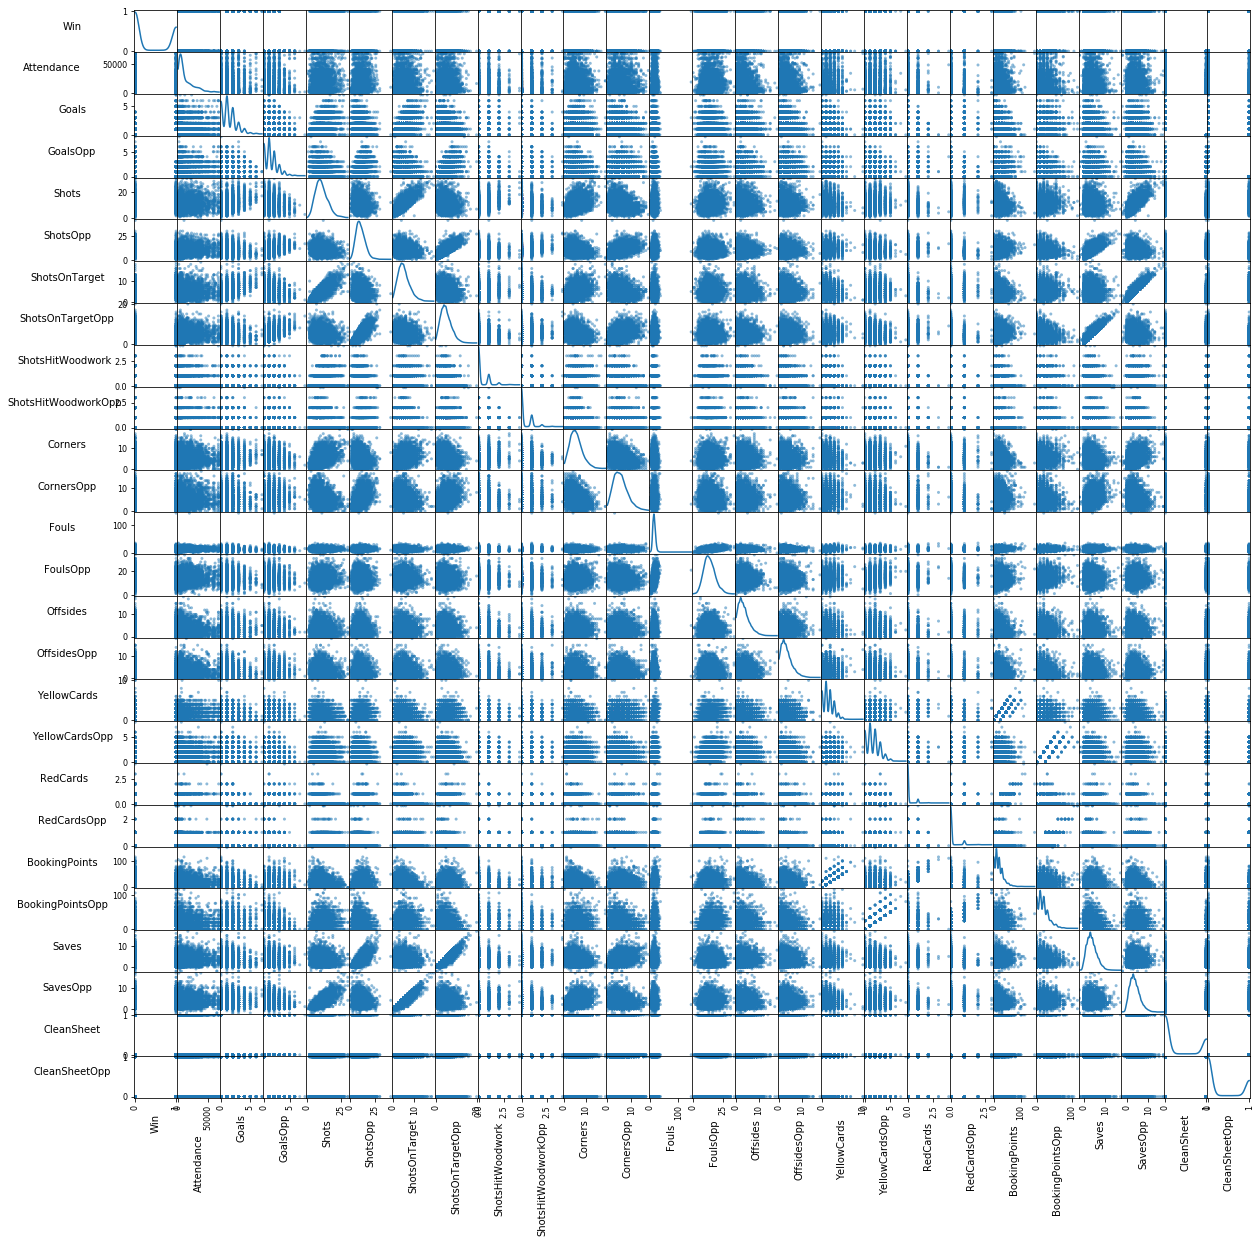

In [7]:
# scatter matrix for all features
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
plot = scatter_matrix(df, diagonal="kde", figsize=(20, 20))
n = len(df.columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = plot[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50

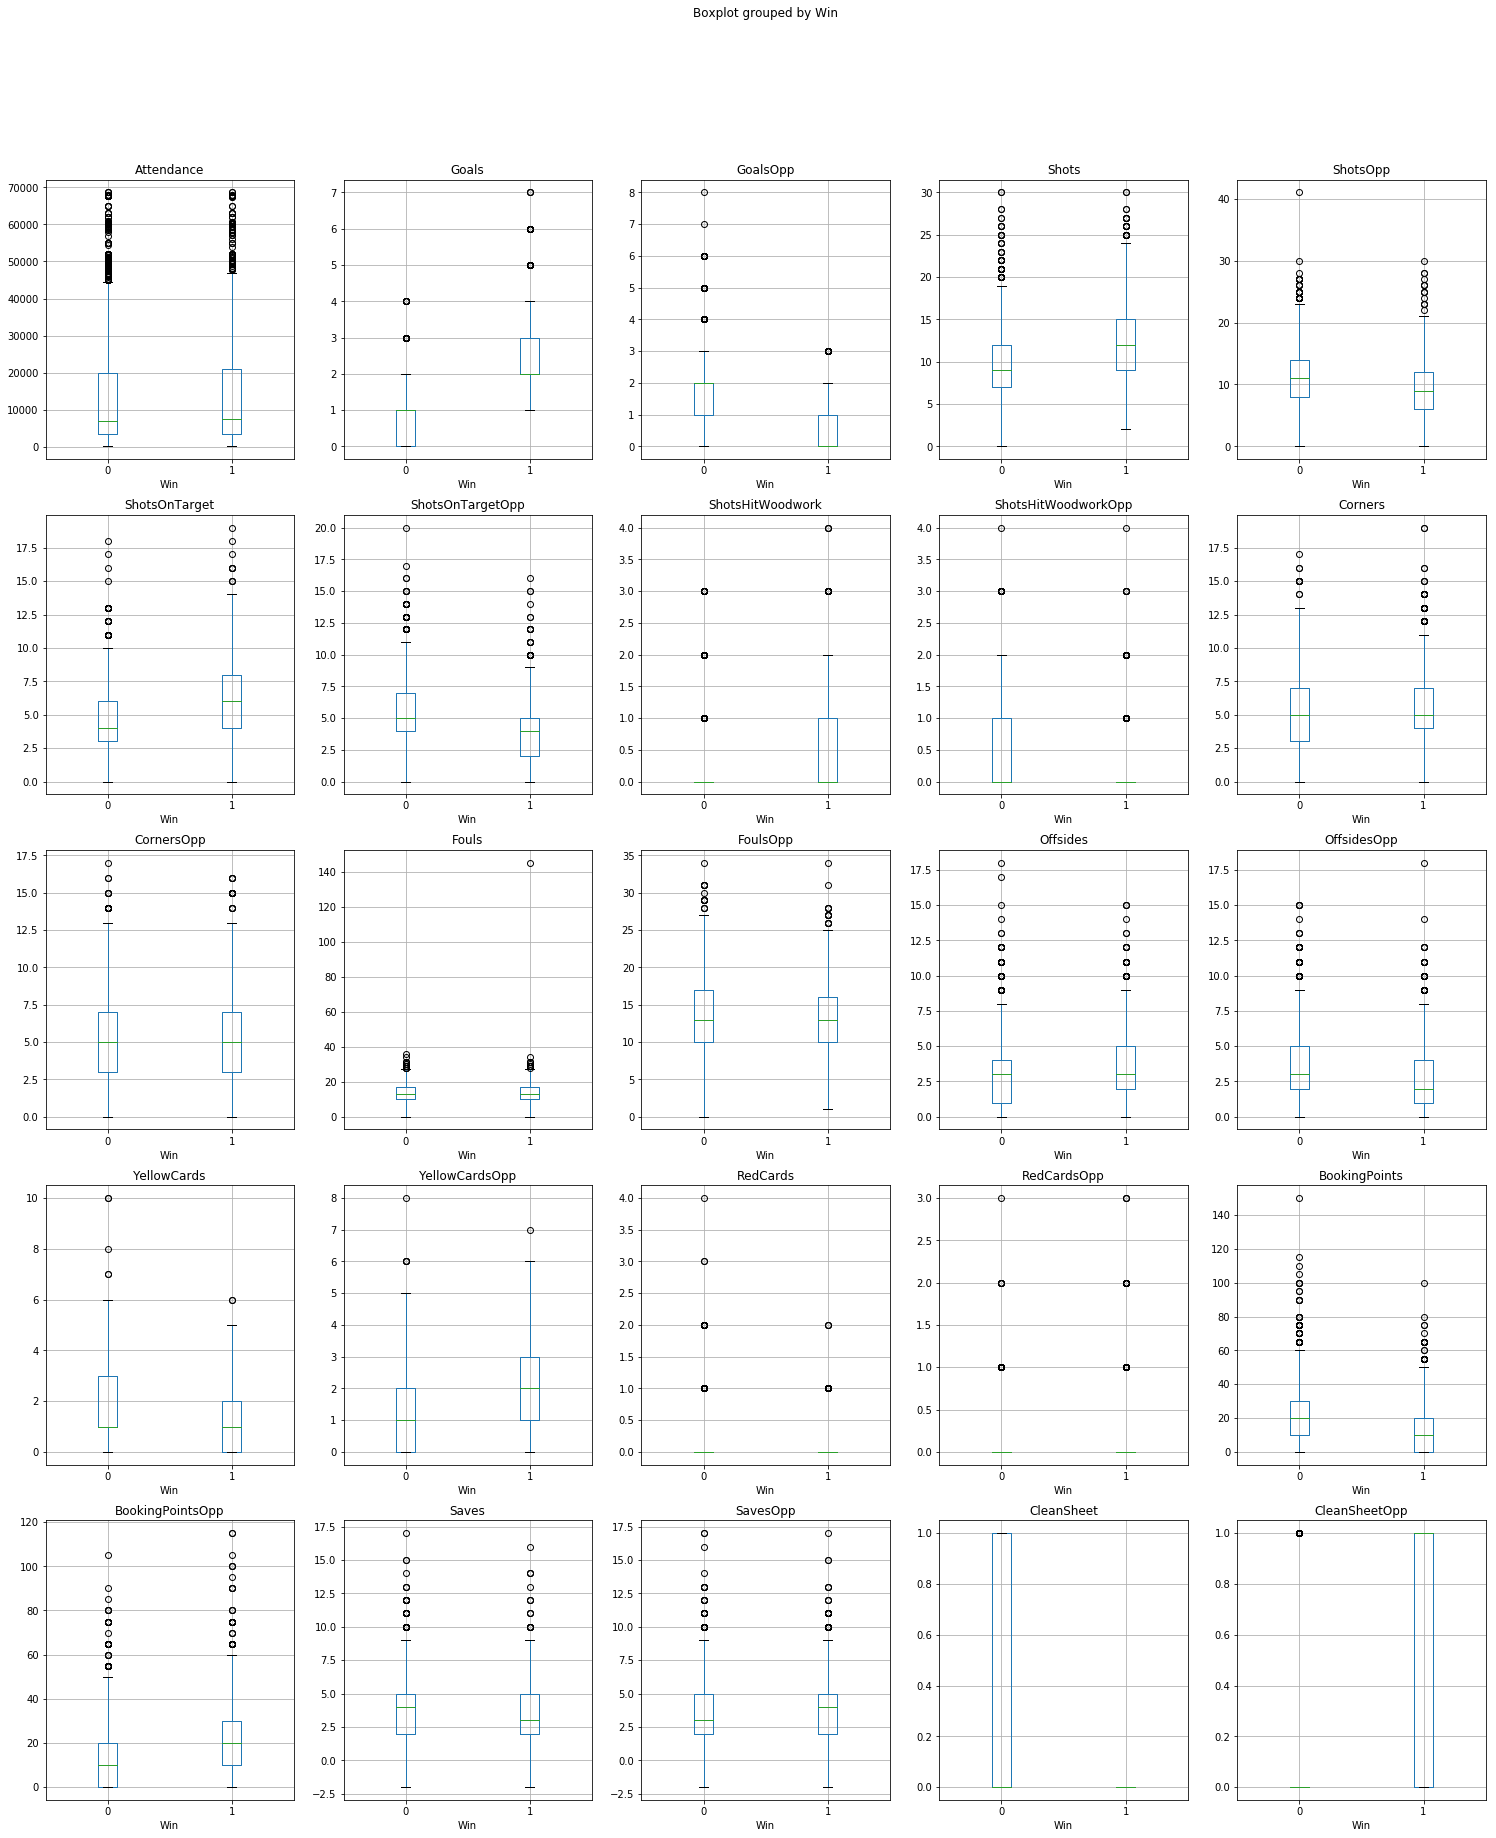

In [8]:
# box plots for all features
features_list.remove("Win")
fig, axs = plt.subplots(nrows=5, ncols=5, sharey=False, figsize=(25, 30))
plot = df.boxplot(column=features_list, by='Win', ax=axs)
features_list = ["Win"] + features_list

In [9]:
# negative Saves - set to zero?
df[(df["Saves"] < 0) | (df["SavesOpp"] < 0)][["ShotsOnTargetOpp", "GoalsOpp", "Saves", "ShotsOnTarget", "Goals", "SavesOpp"]].head(20)

,ShotsOnTargetOpp,GoalsOpp,Saves,ShotsOnTarget,Goals,SavesOpp
MatchIndex,,,,,,
Hansa Rostock vs Leverkusen (2000-09-16),9.0,1.0,8.0,1.0,2.0,-1.0
Aachen vs Mainz (2001-12-19),4.0,0.0,4.0,0.0,1.0,-1.0
Cottbus vs Werder Bremen (2000-08-12),2.0,3.0,-1.0,3.0,1.0,2.0
Werder Bremen vs Cottbus (2000-08-12),3.0,1.0,2.0,2.0,3.0,-1.0
Nott'm Forest vs Wolves (2002-03-06),5.0,2.0,3.0,1.0,2.0,-1.0
Unterhaching vs Schalke 04 (2001-05-19),3.0,5.0,-2.0,1.0,3.0,-2.0
Leverkusen vs Kaiserslautern (2002-03-30),6.0,2.0,4.0,3.0,4.0,-1.0
Schalke 04 vs Unterhaching (2001-05-19),1.0,3.0,-2.0,3.0,5.0,-2.0
Brighton vs Wrexham (2001-09-14),6.0,1.0,5.0,0.0,2.0,-2.0


In [10]:
# Saves are just calc-ed as ShotsOnTarget minus Goals
# but I guess in some cases Goals are scored without ShotsOnTarget (eg. an own goal)
# Let's just set these to zero for now
df.loc[df["Saves"] < 0, 'Saves'] = 0
df.loc[df["SavesOpp"] < 0, 'SavesOpp'] = 0
df[(df["Saves"] < 0) | (df["SavesOpp"] < 0)][["ShotsOnTargetOpp", "GoalsOpp", "Saves", "ShotsOnTarget", "Goals", "SavesOpp"]].head(20)

,ShotsOnTargetOpp,GoalsOpp,Saves,ShotsOnTarget,Goals,SavesOpp
MatchIndex,,,,,,


In [11]:
# improbably high number of fouls
df[(df["Fouls"] > 40)][["Fouls", "YellowCards", "RedCards", "FoulsOpp", "YellowCardsOpp", "RedCardsOpp"]].head(20)

,Fouls,YellowCards,RedCards,FoulsOpp,YellowCardsOpp,RedCardsOpp
MatchIndex,,,,,,
Bielefeld vs Hannover (2002-04-22),145.0,4.0,0.0,21.0,2.0,0.0


In [12]:
# checked the source file and I believe this was just a mistyping of 15
df.at['Bielefeld vs Hannover (2002-04-22)', 'Fouls'] = 15
df[(df["Fouls"] > 40)][["Fouls", "YellowCards", "RedCards", "FoulsOpp", "YellowCardsOpp", "RedCardsOpp"]].head(20)

,Fouls,YellowCards,RedCards,FoulsOpp,YellowCardsOpp,RedCardsOpp
MatchIndex,,,,,,


## Build model

In [13]:
# Extract labels from dataframe
labels = df["Win"].values
labels

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [14]:
# Extract features from dataframe
features_list.remove("Win")
features = df[features_list].values
features

array([[  5.78700000e+03,   1.00000000e+00,   1.00000000e+00, ...,
          3.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  6.32000000e+03,   2.00000000e+00,   0.00000000e+00, ...,
          2.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.18300000e+03,   3.00000000e+00,   1.00000000e+00, ...,
          4.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  4.43200000e+03,   2.00000000e+00,   0.00000000e+00, ...,
          4.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.14200000e+03,   1.00000000e+00,   3.00000000e+00, ...,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.20650000e+04,   2.00000000e+00,   1.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [15]:
# Scale the features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# other option would StandardScaler()
features = scaler.fit_transform(features)
features

array([[ 0.08235208,  0.14285714,  0.125     , ...,  0.17647059,
         0.        ,  0.        ],
       [ 0.09013879,  0.28571429,  0.        , ...,  0.11764706,
         0.        ,  1.        ],
       [ 0.02970051,  0.42857143,  0.125     , ...,  0.23529412,
         0.        ,  0.        ],
       ..., 
       [ 0.06255661,  0.28571429,  0.        , ...,  0.23529412,
         0.        ,  1.        ],
       [ 0.11675676,  0.14285714,  0.375     , ...,  0.11764706,
         0.        ,  0.        ],
       [ 0.3201607 ,  0.28571429,  0.125     , ...,  0.        ,
         0.        ,  0.        ]])

In [16]:
# Split training and testing data
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.1, random_state=42)
features_train.shape

(3600L, 25L)

In [17]:
# build initial model using Naive Bayes algorithm
from sklearn.naive_bayes import GaussianNB
bayes_clf = GaussianNB()
bayes_clf.fit(features_train, labels_train)
bayes_clf.score(features_test, labels_test)

0.72499999999999998

In [18]:
# build a better(?) model using Decision Tree algorithm
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()
tree_clf.fit(features_train, labels_train)
tree_clf.score(features_test, labels_test)

1.0

In [19]:
# Too good to be true? Let's check the various feature importances
for n, imp in enumerate(tree_clf.feature_importances_):
    print("{0}, {1}, {2}".format(n, features_list[n], imp))

0, Attendance, 0.0
1, Goals, 0.632609932044
2, GoalsOpp, 0.229949986594
3, Shots, 0.0
4, ShotsOpp, 0.0
5, ShotsOnTarget, 0.0
6, ShotsOnTargetOpp, 0.0
7, ShotsHitWoodwork, 0.0
8, ShotsHitWoodworkOpp, 0.0
9, Corners, 0.0
10, CornersOpp, 0.0
11, Fouls, 0.0
12, FoulsOpp, 0.0
13, Offsides, 0.0
14, OffsidesOpp, 0.0
15, YellowCards, 0.0
16, YellowCardsOpp, 0.0
17, RedCards, 0.0
18, RedCardsOpp, 0.0
19, BookingPoints, 0.0
20, BookingPointsOpp, 0.0
21, Saves, 0.0
22, SavesOpp, 0.0
23, CleanSheet, 0.0
24, CleanSheetOpp, 0.137440081363


In [20]:
# Remove Goals/GoalsOpp
features_list.remove("Goals")
features_list.remove("GoalsOpp")
features = df[features_list].values
features = scaler.fit_transform(features)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.1, random_state=42)
features_train.shape

(3600L, 23L)

In [21]:
# retry the Decision Tree algorithm
tree_clf = DecisionTreeClassifier()
tree_clf.fit(features_train, labels_train)
tree_clf.score(features_test, labels_test)

0.91249999999999998

In [22]:
# Let's re-check the various feature importances
for n, imp in enumerate(tree_clf.feature_importances_):
    print("{0}, {1}, {2}".format(n, features_list[n], imp))

0, Attendance, 0.0176021320736
1, Shots, 0.0073477130074
2, ShotsOpp, 0.0154477556441
3, ShotsOnTarget, 0.118938213792
4, ShotsOnTargetOpp, 0.0546948258281
5, ShotsHitWoodwork, 0.00288288311926
6, ShotsHitWoodworkOpp, 0.00276973241663
7, Corners, 0.00894309946417
8, CornersOpp, 0.0120617634232
9, Fouls, 0.0183270798416
10, FoulsOpp, 0.00800721210907
11, Offsides, 0.0110903873729
12, OffsidesOpp, 0.00866042315124
13, YellowCards, 0.00735344284962
14, YellowCardsOpp, 0.00163641290765
15, RedCards, 0.0
16, RedCardsOpp, 0.00170367708508
17, BookingPoints, 0.00227506997905
18, BookingPointsOpp, 0.00783004142463
19, Saves, 0.0313210096219
20, SavesOpp, 0.137357257363
21, CleanSheet, 0.234994905128
22, CleanSheetOpp, 0.288754962398


In [23]:
# make predictions on test data
from sklearn.metrics import classification_report
labels_pred = tree_clf.predict(features_test)
print(classification_report(labels_test, labels_pred))

             precision    recall  f1-score   support

          0       0.92      0.94      0.93       252
          1       0.90      0.86      0.88       148

avg / total       0.91      0.91      0.91       400



In [24]:
# tune the number of features
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV

n_features = np.arange(1, len(features_list))

# Create a pipeline with feature selection and classification
tree_pipe = Pipeline([
    ('select_features', SelectKBest()),
    ('classify', DecisionTreeClassifier())
])
tree_params = [
    {
        'select_features__k': n_features
    }
]
# Use GridSearchCV to automate the process of finding the optimal number of features
tree_clf= GridSearchCV(tree_pipe, param_grid=tree_params, scoring='f1', cv=10)
tree_clf.fit(features_train, labels_train)

tree_clf.best_estimator_

Pipeline(steps=[('select_features', SelectKBest(k=21, score_func=<function f_classif at 0x0000000033C58BA8>)), ('classify', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])

In [25]:
# make predictions on test data (again)
labels_pred = tree_clf.predict(features_test)
print(classification_report(labels_test, labels_pred))

             precision    recall  f1-score   support

          0       0.92      0.92      0.92       252
          1       0.87      0.87      0.87       148

avg / total       0.91      0.91      0.91       400



In [26]:
# tune the hyperameters